In [18]:
%cd /data/nijhawanlab/amplicons/VK005/
R1_file = "VK005_R1_001.fastq.gz"
R2_file = "VK005_R2_001.fastq.gz"
primer_file = "primers.txt"
experiment = "VK005"

/data/nijhawanlab/amplicons/VK005


```
seqkit stats *.fastq.gz   
file                   format  type  num_seqs     sum_len  min_len  avg_len  max_len
VK005_R1_001.fastq.gz  FASTQ   DNA    142,886  26,178,553       35    183.2      250
VK005_R2_001.fastq.gz  FASTQ   DNA    142,886  26,496,850       35    185.4      250
```

In [4]:
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA' # TTCTTGACGAGTTCTTCTGA
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC' # ACGCGTCTGGAACAATCAAC
reference_barcode = 'SWSWSWSWSWSWSWSWSWSW'

In [5]:
# This works to make output cell wide, with a horiztonal scroll bar.
# https://stackoverflow.com/questions/48357459/make-cell-output-in-jupyter-notebook-scroll-horizontally
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [6]:
# change the cell width
# This doesn't scroll, just makes the cells wide.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re
# import xlwt, openpyxl
import colored

In [8]:
pd.__version__

'1.0.3'

In [9]:
basePair = {'A':'T','T':'A','G':'C','C':'G'}
basePairTrans = str.maketrans(basePair)
def rcDNA(seq):
    return seq.translate(basePairTrans) [::-1]
def cDNA(seq):
    return seq.translate(basePairTrans)

In [10]:
def IdPrimers(seq):
    found_primers = {
        'fwd_primer':None,
        'fwd_primer_loc':None, 
        'rc_primer':None, 
        'rc_primer_loc':None, 
        'fwd_direction':None,
        'rc_direction':None
    }
    for p in primers:
        p1 = seq.find(p['sequence'])
        if p1 != -1:
            found_primers['fwd_primer'] = p['OriginalSeq']
            found_primers['fwd_primer_loc'] = p1
            found_primers['fwd_direction'] = p['direction']
        p2 = seq.rfind( rcDNA( p['sequence'] ))
        if p2 != -1:
            found_primers['rc_primer'] = p['OriginalSeq']
            found_primers['rc_primer_loc'] = p2
            found_primers['rc_direction'] = p['direction']
    return found_primers

In [11]:
from colored import fg, bg, attr
from itertools import cycle

def colorIntervals(seq, intervals, 
                   default_color = bg('black')+fg('white'), 
                   color_list = [bg('grey_50')+fg('black'), bg('grey_85')+fg('white'), bg('grey_50')+fg('black'), bg('orange_red_1'), bg('dark_blue')], 
                   offset=0):
    color = cycle(color_list)
    intervals.sort()
    if any(intervals[i+1][0]-intervals[i][1] <=0 for i in range(len(intervals)-1)):
        print("ColorSeq: Intervals cannot overlap.")
        return seq
    colored_string = default_color + offset*' ' # seq[:intervals[0][0]]
    last_index = 0 # intervals[0][1]
    for interval in intervals:
        colored_string += seq[last_index:interval[0]]
        c = next(color)
        colored_string += c + seq[interval[0]:interval[1]] + default_color
        last_index = interval[1]
    colored_string += seq[last_index:] + bg(0) + fg(0) + attr('reset')
    return colored_string

## Read Input Files

### Read in primers.txt and store primers in various useful forms

In [13]:
primers = []
with open(primer_file, newline='') as primers_IO:
    primer_reader = csv.DictReader(primers_IO, delimiter='\t', fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primers.append(dict(primer))

primers

[{'OriginalSeq': 'oVK025',
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCTTG ',
  'direction': 'F'},
 {'OriginalSeq': 'oVK031',
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'barcode': 'GCCGAA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK032',
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'barcode': 'TACTGC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK033',
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'barcode': 'GAACGT',
  'direction': 'F'},
 {'OriginalSeq': 'oVK034',
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'barcode': 'TATCCA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK035',
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'barcode': 'CTCCGG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK036',
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCACC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK037',
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCGAG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK026',
  'sequence': 'TTTTGTCACCCAGAGGTTGAT

In [14]:
forward_primers = [p['OriginalSeq'] for p in primers if p['direction']=='F']
reverse_primers = [p['OriginalSeq'] for p in primers if p['direction']=='R']

[forward_primers, reverse_primers]

[['oVK025',
  'oVK031',
  'oVK032',
  'oVK033',
  'oVK034',
  'oVK035',
  'oVK036',
  'oVK037'],
 ['oVK026',
  'oVK038',
  'oVK039',
  'oVK040',
  'oVK041',
  'oVK042',
  'oVK043',
  'oVK044',
  'oVK045',
  'oVK046',
  'oVK047',
  'oVK048']]

In [15]:
primer_lookup = {p['OriginalSeq']: 
                 {'len':len(p['sequence']), 
                  'sequence':p['sequence'],
                  'direction':p['direction']
                 } for p in primers}

In [16]:
primer_lookup

{'oVK025': {'len': 28,
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK031': {'len': 28,
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK032': {'len': 28,
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK033': {'len': 28,
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK034': {'len': 28,
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK035': {'len': 28,
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK036': {'len': 28,
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK037': {'len': 28,
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK026': {'len': 30,
  'sequence': 'TTTTGTCACCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK038': {'len': 30,
  'sequence': 'TTTGTTAATCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK039': {'len': 30,
  'sequence': 'TTTTATGGTCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oV

### Load paired reads from FASTQ files

In [19]:
R1 = gzip.open(R1_file, "rt")
R2 = gzip.open(R2_file, "rt")
reads1 = SeqIO.parse(R1, "fastq")
reads2 = SeqIO.parse(R2, "fastq")
maxReads = 200000
readNumber = 0
reads_list = []
for (read1, read2) in zip(reads1, reads2):
    R1_sequence = str(read1.seq)
    R2_sequence = str(read2.seq)
    
    R1_primers = IdPrimers(R1_sequence)
    R2_primers = IdPrimers(R2_sequence)
    
    full_read = {}
    full_read.update({'R1_'+k:R1_primers[k] for k in R1_primers})
    full_read.update({'R2_'+k:R2_primers[k] for k in R2_primers})
    full_read.update({
        'R1_sequence':R1_sequence,
        'R2_sequence':R2_sequence
    })

    if(not None in full_read.values() ):       
        reads_list.append(full_read)
    # print(full_read)
    readNumber += 1
    if readNumber > maxReads:
        break

print("maxReads: {}\nTotal reads: {}".format(maxReads,readNumber-1))
reads_table = pd.DataFrame(reads_list)
        
R1.close()
R2.close()

maxReads: 200000
Total reads: 142885


### Define calculated columns in the reads_table

In [20]:
reads_table['forward_primer']=reads_table['R1_fwd_primer'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R1_rc_primer'])
reads_table['reverse_primer']=reads_table['R1_rc_primer'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R1_fwd_primer'])
reads_table['sequence']=reads_table['R1_sequence'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R2_sequence'])

In [21]:
reads_table['R1_pre_loc']=reads_table['R1_sequence'].apply(lambda s: s.find(reference_sequence_pre)).where(
    reads_table['R1_fwd_direction']=='F',
    reads_table['R1_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_pre) ))
)
reads_table['R1_post_loc']=reads_table['R1_sequence'].apply(lambda s: s.find(reference_sequence_post)).where(
    reads_table['R1_fwd_direction']=='F',
    reads_table['R1_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_post) ))

)
reads_table['R2_pre_loc']=reads_table['R2_sequence'].apply(lambda s: s.find(reference_sequence_pre)).where(
    reads_table['R2_fwd_direction']=='F',
    reads_table['R2_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_pre) ))
)
reads_table['R2_post_loc']=reads_table['R2_sequence'].apply(lambda s: s.find(reference_sequence_post)).where(
    reads_table['R2_fwd_direction']=='F',
    reads_table['R2_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_post) ))
)

In [22]:
reads_table['R1_barcode_loc']=reads_table.apply(
    lambda row: [row['R1_pre_loc']+len(reference_sequence_pre), row['R1_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='F',
        reads_table.apply(
            lambda row: [row['R1_post_loc']+len(reference_sequence_post), row['R1_pre_loc']] , axis=1)
)

reads_table['R2_barcode_loc']=reads_table.apply(
    lambda row: [row['R2_pre_loc']+len(reference_sequence_pre), row['R2_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='R',
        reads_table.apply(
            lambda row: [row['R2_post_loc']+len(reference_sequence_post), row['R2_pre_loc']], axis=1)
)

reads_table['R1_barcode']=reads_table.apply(
    lambda row: row['R1_sequence'][row['R1_pre_loc']+len(reference_sequence_pre):row['R1_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='F',
        reads_table.apply(
            lambda row: rcDNA( row['R1_sequence'][row['R1_post_loc']+len(reference_sequence_post):row['R1_pre_loc']] ), axis=1)
)

reads_table['R2_barcode']=reads_table.apply(
    lambda row: row['R2_sequence'][row['R2_pre_loc']+len(reference_sequence_pre):row['R2_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='R',
        reads_table.apply(
            lambda row: rcDNA( row['R2_sequence'][row['R2_post_loc']+len(reference_sequence_post):row['R2_pre_loc']] ), axis=1)
)

### Filtering

Column `sanity` accumulates all our checks on the correctness of the reads.  Start by checking that the primers for the forward and reverse reads are the same, and that the inferred directionality matches.

In [23]:
reads_table['sanity'] = (
    (reads_table['R1_fwd_primer'] == reads_table['R2_rc_primer']) &
    (reads_table['R1_rc_primer'] == reads_table['R2_fwd_primer']) &
    (reads_table['R1_fwd_direction'] == reads_table['R2_rc_direction']) &
    (reads_table['R1_rc_direction'] == reads_table['R2_fwd_direction']) &
    (reads_table['R1_fwd_direction'] != reads_table['R1_rc_direction']) 
)

Now check that the barcodes in both paired reads match each other and match the defined pattern.

In [24]:
barcode_regex = re.compile('([GC][AT])+')

def checkBarcodePattern(b):
    if barcode_regex.fullmatch(b):
        return True
    else:
        return False

reads_table['sanity'] = (
    reads_table['sanity'] & 
    # reads_table['R1_barcode'].apply( checkBarcodePattern ) &
    (reads_table['R1_barcode']==reads_table['R2_barcode'])
)

reads_table['barcode_length']=reads_table['R1_barcode'].apply( len )

In [25]:
reads_table

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,...,R1_pre_loc,R1_post_loc,R2_pre_loc,R2_post_loc,R1_barcode_loc,R2_barcode_loc,R1_barcode,R2_barcode,sanity,barcode_length
0,oVK040,0,oVK035,157,R,F,oVK035,0,oVK040,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGACTGTGAGACACTGTGACAGA,GTGACTGTGAGACACTGTGACAGA,True,24
1,oVK038,0,oVK033,157,R,F,oVK033,0,oVK038,155,...,59,15,106,150,"[35, 59]","[126, 150]",CTGTCTCTGTCTGTGACAGAGTGT,CTGTCTCTGTCTGTGACAGAGTGT,True,24
2,oVK045,0,oVK035,156,R,F,oVK035,0,oVK045,154,...,58,15,106,149,"[35, 58]","[126, 149]",GAGTCTGTGTCAGTGACTTCTGT,GAGTCTGTGTCAGTGACTTCTGT,True,23
3,oVK043,0,oVK032,157,R,F,oVK032,0,oVK043,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGAGTCAGAGAGAGTGAGACTGT,GTGAGTCAGAGAGAGTGAGACTGT,True,24
4,oVK032,0,oVK046,154,F,R,oVK046,0,oVK032,156,...,-1,149,-1,15,"[19, 149]","[35, -1]",AAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGG...,CTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCG...,False,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77992,oVK031,0,oVK038,155,F,R,oVK038,0,oVK031,157,...,106,150,59,15,"[126, 150]","[35, 59]",CACTGTGTCACAGACTCTCACAGA,CACTGTGTCACAGACTCTCACAGA,True,24
77993,oVK032,0,oVK038,159,F,R,oVK038,0,oVK032,161,...,106,154,63,15,"[126, 154]","[35, 63]",CTCAGACACACTCAGTCTGAGTGAGACA,CTCAGACACACTCAGTCTGAGTGAGACA,True,28
77994,oVK033,0,oVK048,155,F,R,oVK048,0,oVK033,157,...,106,150,59,15,"[126, 150]","[35, 59]",GACTGACAGTCAGACTCACACTGT,GACTGACAGTCAGACTCACACTGT,True,24
77995,oVK034,0,oVK047,154,F,R,oVK047,0,oVK034,156,...,106,149,58,15,"[126, 149]","[35, 58]",GAGAGAGACAGACAGAACTCAGA,GAGAGAGACAGACAGAACTCAGA,True,23


In [26]:
reads_table[reads_table['sanity'] == True]

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,...,R1_pre_loc,R1_post_loc,R2_pre_loc,R2_post_loc,R1_barcode_loc,R2_barcode_loc,R1_barcode,R2_barcode,sanity,barcode_length
0,oVK040,0,oVK035,157,R,F,oVK035,0,oVK040,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGACTGTGAGACACTGTGACAGA,GTGACTGTGAGACACTGTGACAGA,True,24
1,oVK038,0,oVK033,157,R,F,oVK033,0,oVK038,155,...,59,15,106,150,"[35, 59]","[126, 150]",CTGTCTCTGTCTGTGACAGAGTGT,CTGTCTCTGTCTGTGACAGAGTGT,True,24
2,oVK045,0,oVK035,156,R,F,oVK035,0,oVK045,154,...,58,15,106,149,"[35, 58]","[126, 149]",GAGTCTGTGTCAGTGACTTCTGT,GAGTCTGTGTCAGTGACTTCTGT,True,23
3,oVK043,0,oVK032,157,R,F,oVK032,0,oVK043,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGAGTCAGAGAGAGTGAGACTGT,GTGAGTCAGAGAGAGTGAGACTGT,True,24
5,oVK026,0,oVK032,157,R,F,oVK032,0,oVK026,155,...,59,15,106,150,"[35, 59]","[126, 150]",GAGTGAGTGTCTGAGTGTGACTCT,GAGTGAGTGTCTGAGTGTGACTCT,True,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77992,oVK031,0,oVK038,155,F,R,oVK038,0,oVK031,157,...,106,150,59,15,"[126, 150]","[35, 59]",CACTGTGTCACAGACTCTCACAGA,CACTGTGTCACAGACTCTCACAGA,True,24
77993,oVK032,0,oVK038,159,F,R,oVK038,0,oVK032,161,...,106,154,63,15,"[126, 154]","[35, 63]",CTCAGACACACTCAGTCTGAGTGAGACA,CTCAGACACACTCAGTCTGAGTGAGACA,True,28
77994,oVK033,0,oVK048,155,F,R,oVK048,0,oVK033,157,...,106,150,59,15,"[126, 150]","[35, 59]",GACTGACAGTCAGACTCACACTGT,GACTGACAGTCAGACTCACACTGT,True,24
77995,oVK034,0,oVK047,154,F,R,oVK047,0,oVK034,156,...,106,149,58,15,"[126, 149]","[35, 58]",GAGAGAGACAGACAGAACTCAGA,GAGAGAGACAGACAGAACTCAGA,True,23


In [27]:
reads_table.columns

Index(['R1_fwd_primer', 'R1_fwd_primer_loc', 'R1_rc_primer',
       'R1_rc_primer_loc', 'R1_fwd_direction', 'R1_rc_direction',
       'R2_fwd_primer', 'R2_fwd_primer_loc', 'R2_rc_primer',
       'R2_rc_primer_loc', 'R2_fwd_direction', 'R2_rc_direction',
       'R1_sequence', 'R2_sequence', 'forward_primer', 'reverse_primer',
       'sequence', 'R1_pre_loc', 'R1_post_loc', 'R2_pre_loc', 'R2_post_loc',
       'R1_barcode_loc', 'R2_barcode_loc', 'R1_barcode', 'R2_barcode',
       'sanity', 'barcode_length'],
      dtype='object')

### Examine the data, starting with the first few reads

In [28]:
def invertLocation(loc, seqLen):
    return seqLen - 1 - loc

def printSeqOriented(n, table):
    read = table.iloc[n]
    sequence = read['sequence']
    if read['R1_fwd_direction'] == 'F':
        intervals = [
                [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
                [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
    else:
        l = len(sequence)
        intervals = [
                [read['R2_fwd_primer_loc'], read['R2_fwd_primer_loc'] + primer_lookup[read['R2_fwd_primer']]['len'] ],
                [read['R2_rc_primer_loc'], read['R2_rc_primer_loc'] + primer_lookup[read['R2_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
        intervals = [[l-b,l-a] for [a, b] in intervals]
    # print(intervals)
    highlights = colorIntervals(sequence, intervals)
    return highlights

In [29]:
for i in range(25):
    print( "{0:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction']), printSeqOriented(i, reads_table) )


   0 R GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTGACTGTGAGACACTGTGACAGAACGCGTCTGGAACAATCAACCTCTGTATCTCAAAA
   1 R GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGACTGTCTCTGTCTGTGACAGAGTGTACGCGTCTGGAACAATCAACCTCTGGATTAACAAA
   2 R GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGAGTCTGTGTCAGTGACTTCTGTACGCGTCTGGAACAATCAACCTCTGGTAGAGAAAA
   3 R GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTGAGTCAGAGAGAGTGAGACTGTACGCGTCTGGAACAATCAACCTCTGGAATGGAAAA
ColorSeq: Intervals cannot overlap.
   4 F GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGATGAGTTCTTCTGACACTCTGAGACAGTCTCTAGAGTACGCGTCTGGAACAATCAACCTCTGGATGTAAAAA
 

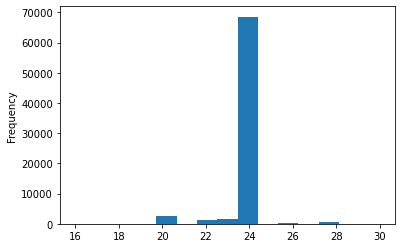

In [30]:
reads_table['barcode_length'].plot.hist(range=(16,30), bins=15)

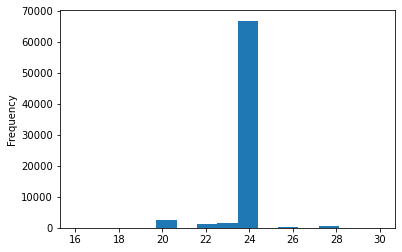

In [31]:
reads_table[reads_table['sanity']==True]['barcode_length'].plot.hist(range=(16,30), bins=15)

From here on, restrict the analysis to reads with `sanity == True`.

In [32]:
good_reads = reads_table[reads_table['sanity']==True][["forward_primer","reverse_primer","R1_barcode"]]
good_reads.columns=(["forward_primer","reverse_primer","barcode"])
good_reads["count"]=1
good_reads

,forward_primer,reverse_primer,barcode,count
0,oVK035,oVK040,GTGACTGTGAGACACTGTGACAGA,1
1,oVK033,oVK038,CTGTCTCTGTCTGTGACAGAGTGT,1
2,oVK035,oVK045,GAGTCTGTGTCAGTGACTTCTGT,1
3,oVK032,oVK043,GTGAGTCAGAGAGAGTGAGACTGT,1
5,oVK032,oVK026,GAGTGAGTGTCTGAGTGTGACTCT,1
...,...,...,...,...
77992,oVK031,oVK038,CACTGTGTCACAGACTCTCACAGA,1
77993,oVK032,oVK038,CTCAGACACACTCAGTCTGAGTGAGACA,1
77994,oVK033,oVK048,GACTGACAGTCAGACTCACACTGT,1
77995,oVK034,oVK047,GAGAGAGACAGACAGAACTCAGA,1


In [33]:
counts_table = good_reads.groupby(by=["forward_primer","reverse_primer","barcode"]).size().reset_index(name="count").sort_values(['forward_primer','reverse_primer','count'], ascending=[True,True,False])
counts_table.columns=["forward_primer","reverse_primer","barcode","count"]
counts_table

,forward_primer,reverse_primer,barcode,count
70,oVK025,oVK026,GTGACAGTGACAGTGAGAGACAGT,184
52,oVK025,oVK026,GAGTGTGTGACACAGTGTCAGTGT,102
45,oVK025,oVK026,GAGTCAGAGTGTCACTGTGAGTCA,56
49,oVK025,oVK026,GAGTGAGTGTCTGAGTGTGACTCT,35
15,oVK025,oVK026,CTCTGACAGACACAGTGACTCTGA,26
...,...,...,...,...
6748,oVK037,oVK048,GTCTGTGACTCTCAGTCTCTCACA,1
6751,oVK037,oVK048,GTGACAGTGTGTCTGTGTGTGAGT,1
6752,oVK037,oVK048,GTGACTGTGAGAGAGTCTCA,1
6754,oVK037,oVK048,GTGTGACAGAGTCTCACACTGTGA,1


In [34]:
little_counts_table = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10))).reset_index()
little_counts_table

,forward_primer,reverse_primer,barcode,count
0,oVK025,oVK026,GTGACAGTGACAGTGAGAGACAGT,184
1,oVK025,oVK026,GAGTGTGTGACACAGTGTCAGTGT,102
2,oVK025,oVK026,GAGTCAGAGTGTCACTGTGAGTCA,56
3,oVK025,oVK026,GAGTGAGTGTCTGAGTGTGACTCT,35
4,oVK025,oVK026,CTCTGACAGACACAGTGACTCTGA,26
...,...,...,...,...
955,oVK037,oVK048,GTGACACACACAGTGTGTGTGAGT,10
956,oVK037,oVK048,GAGAGTGTGAGAGAGAGAGTGTGT,7
957,oVK037,oVK048,CACACAGAGAGACTGACAGAGTCA,6
958,oVK037,oVK048,GACAGAGTCTGTCACTCTGAGTCT,6


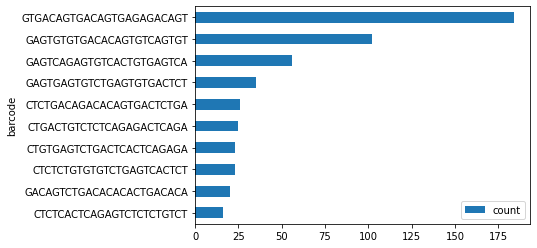

In [35]:
little_counts_table[
    (little_counts_table['forward_primer']=='oVK025') & 
    (little_counts_table['reverse_primer']=='oVK026')].sort_values("count").plot.barh(x="barcode",y="count")

[Text(0, 0.5, '')]

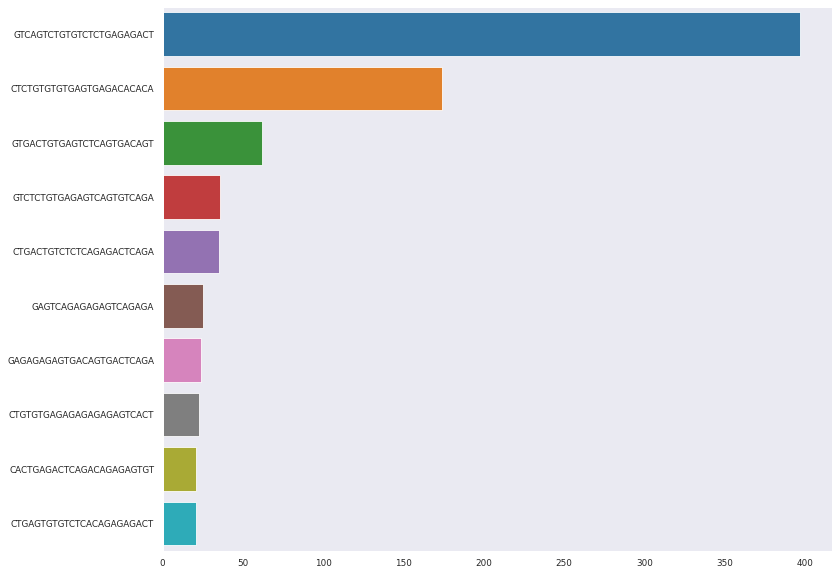

In [36]:
sns.set_style("dark")
sns.set_context("paper")
f, ax = plt.subplots()
f.set_size_inches(12,10)
g = sns.barplot(
        y = "barcode",
        x = "count",
        data=little_counts_table[
            (little_counts_table['forward_primer']=='oVK025') & 
            (little_counts_table['reverse_primer']=='oVK039')].sort_values("count", ascending=False).head(10),
        orient='h', ax=ax
)
g.set(xlabel=None)
g.set(ylabel=None)

Text(0.5, 0.98, 'VK005')

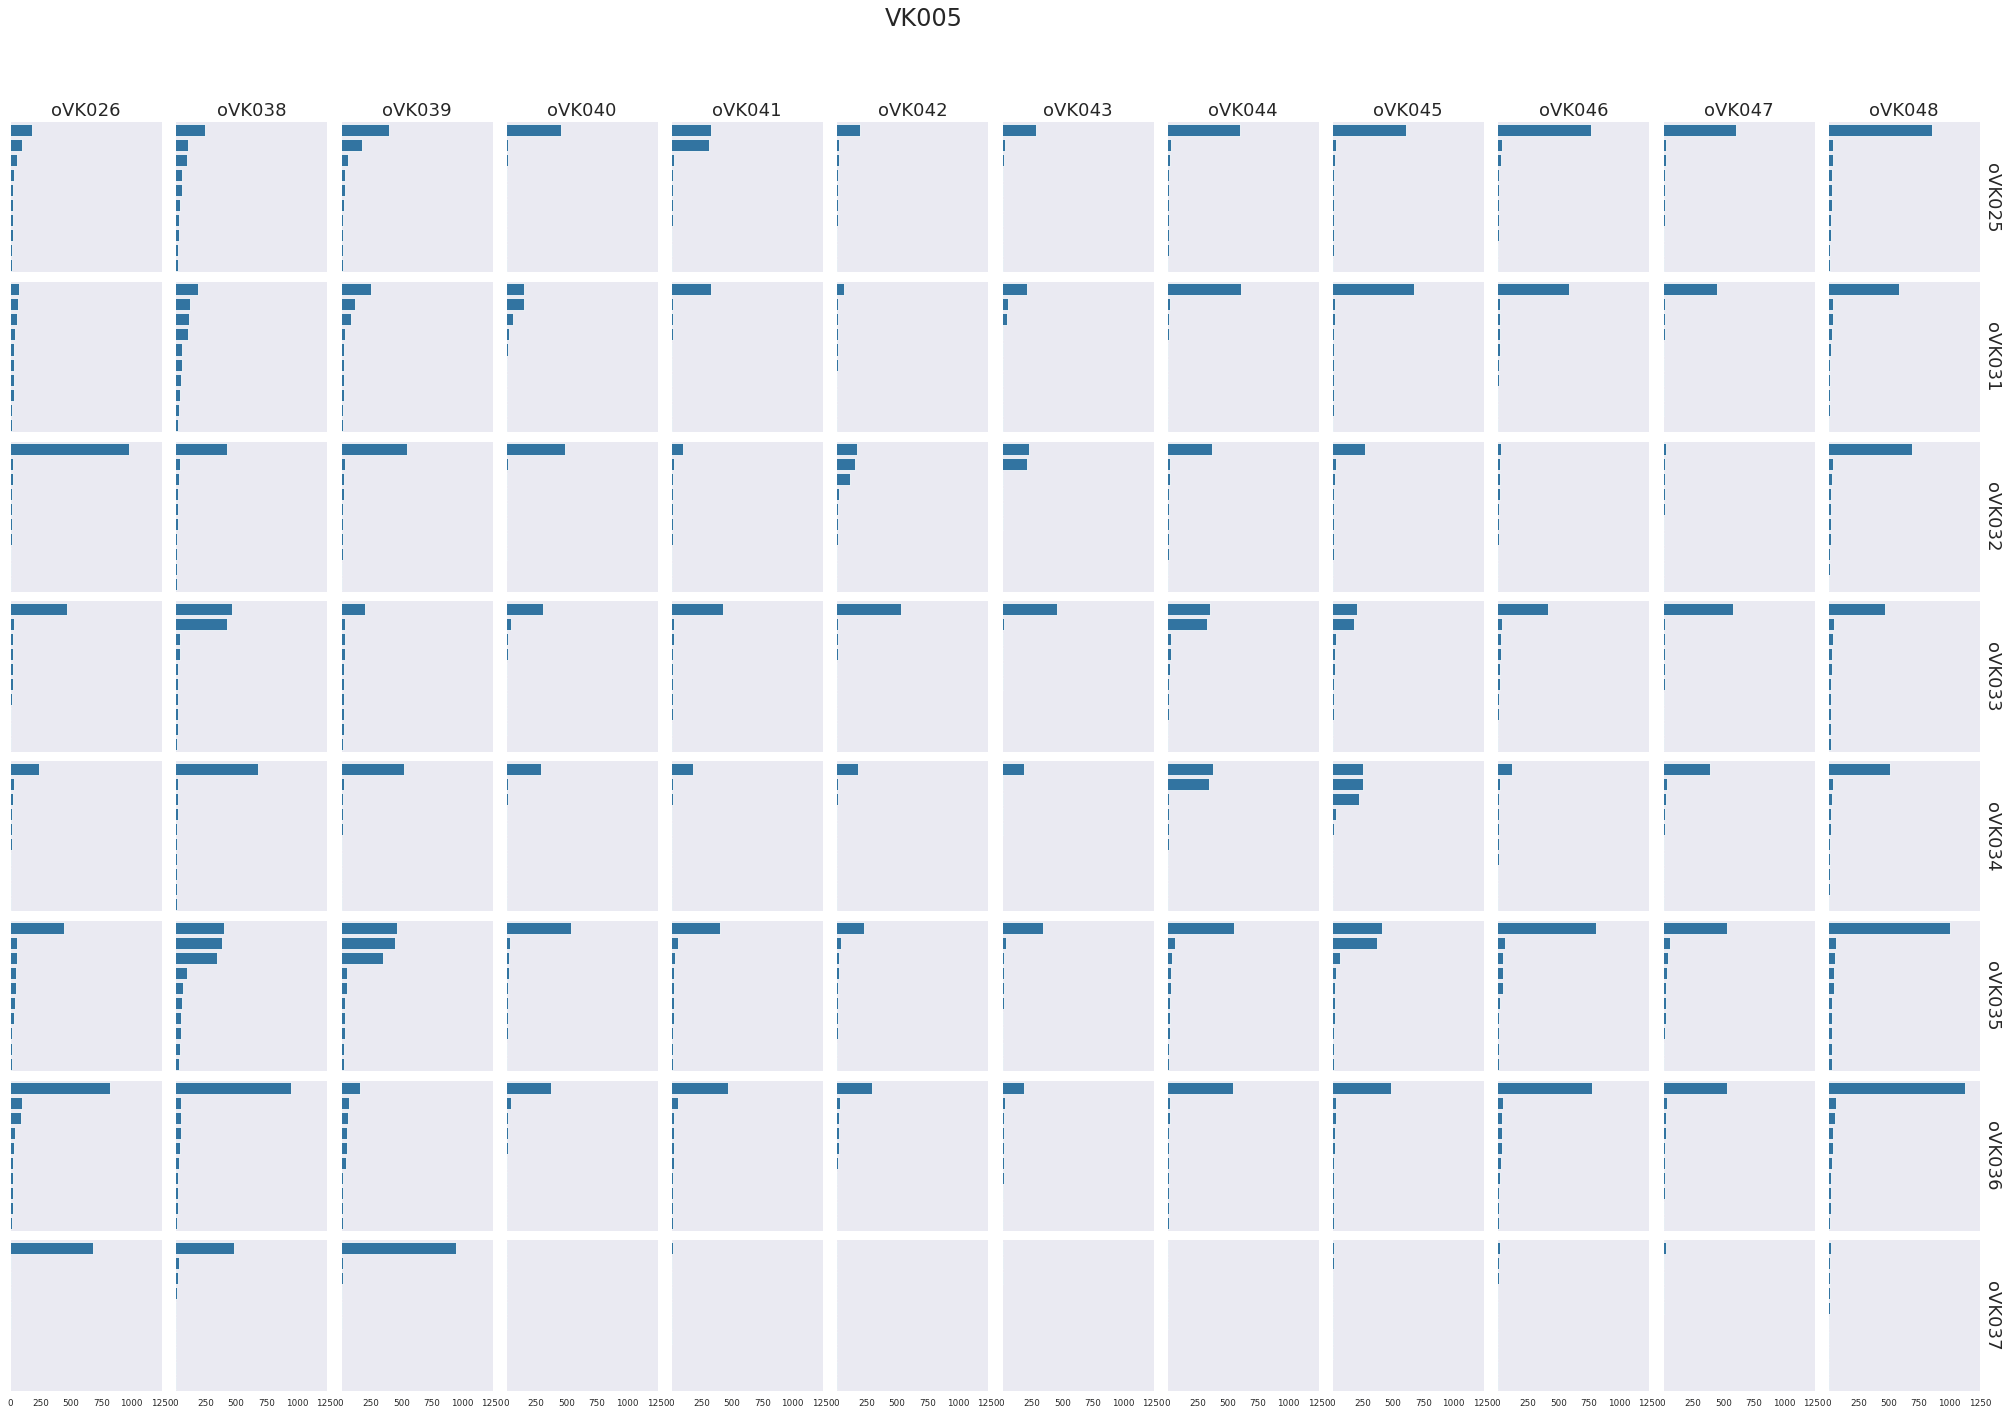

In [37]:
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(little_counts_table, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="count",y="barcode", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.9)
g2.fig.suptitle(experiment, fontsize=24)

In [38]:
little_counts_table[
    (little_counts_table['forward_primer']=='oVK031') & 
    (little_counts_table['reverse_primer']=='oVK044')].sort_values("count", ascending=False)

,forward_primer,reverse_primer,barcode,count
190,oVK031,oVK044,GTGTGTGTGACAGTGACTCAGAGT,611
191,oVK031,oVK044,CTCTCTCACACTGTCTCTCACAGT,22
192,oVK031,oVK044,CTGACTGTCTCTCAGAGACTCAGA,21
193,oVK031,oVK044,CTGTCTCTGTCTGTGACAGAGTGT,16
194,oVK031,oVK044,GTGTGACAGAGTCTCACACTGTGA,13
195,oVK031,oVK044,CACTGTGTGAGTCTCAGACACAGT,12
196,oVK031,oVK044,CAGTGACTCTCTCACTCTGTCACA,12
197,oVK031,oVK044,GAGAGAGACAGACAGAACTCAGA,12
198,oVK031,oVK044,GTCTGTTGTGTGACGCTCCT,11
199,oVK031,oVK044,GAGTGACTGTGTGTGAGTGTCACT,10


In [39]:
top_5_reads = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(5))).reset_index()
top_5_reads["rank"] = top_5_reads.groupby(by=["forward_primer","reverse_primer"]).rank(method="first", ascending=False).astype(int)
top_5_reads

,forward_primer,reverse_primer,barcode,count,rank
0,oVK025,oVK026,GTGACAGTGACAGTGAGAGACAGT,184,1
1,oVK025,oVK026,GAGTGTGTGACACAGTGTCAGTGT,102,2
2,oVK025,oVK026,GAGTCAGAGTGTCACTGTGAGTCA,56,3
3,oVK025,oVK026,GAGTGAGTGTCTGAGTGTGACTCT,35,4
4,oVK025,oVK026,CTCTGACAGACACAGTGACTCTGA,26,5
...,...,...,...,...,...
475,oVK037,oVK048,GACAGTGACTGTGAGAGAGTCTCA,28,1
476,oVK037,oVK048,CTGTGAGTCTGACTCACTCAGAGA,20,2
477,oVK037,oVK048,GTCTGTCTCAGTCACACACAGTGT,19,3
478,oVK037,oVK048,GTGACTGTGAGTCTCAGTGACAGT,17,4


In [40]:
top_5_reads.to_excel('top_5_barcodes.xlsx')

#### Compute the total number of reads, and annotate the plots.

In [41]:
total_reads = good_reads.groupby(by=["forward_primer","reverse_primer"]).size().reset_index(name="count").sort_values(['forward_primer','reverse_primer'], ascending=[True,True])
total_reads.columns=["forward_primer","reverse_primer","count"]
total_reads

,forward_primer,reverse_primer,count
0,oVK025,oVK026,747
1,oVK025,oVK038,1070
2,oVK025,oVK039,1132
3,oVK025,oVK040,628
4,oVK025,oVK041,828
...,...,...,...
91,oVK037,oVK044,87
92,oVK037,oVK045,98
93,oVK037,oVK046,109
94,oVK037,oVK047,117


In [42]:
total_reads[(total_reads['forward_primer']=='oVK025') & (total_reads['reverse_primer']=='oVK041')].iloc[0]['count']

828

Text(0.5, 0.98, 'VK005')

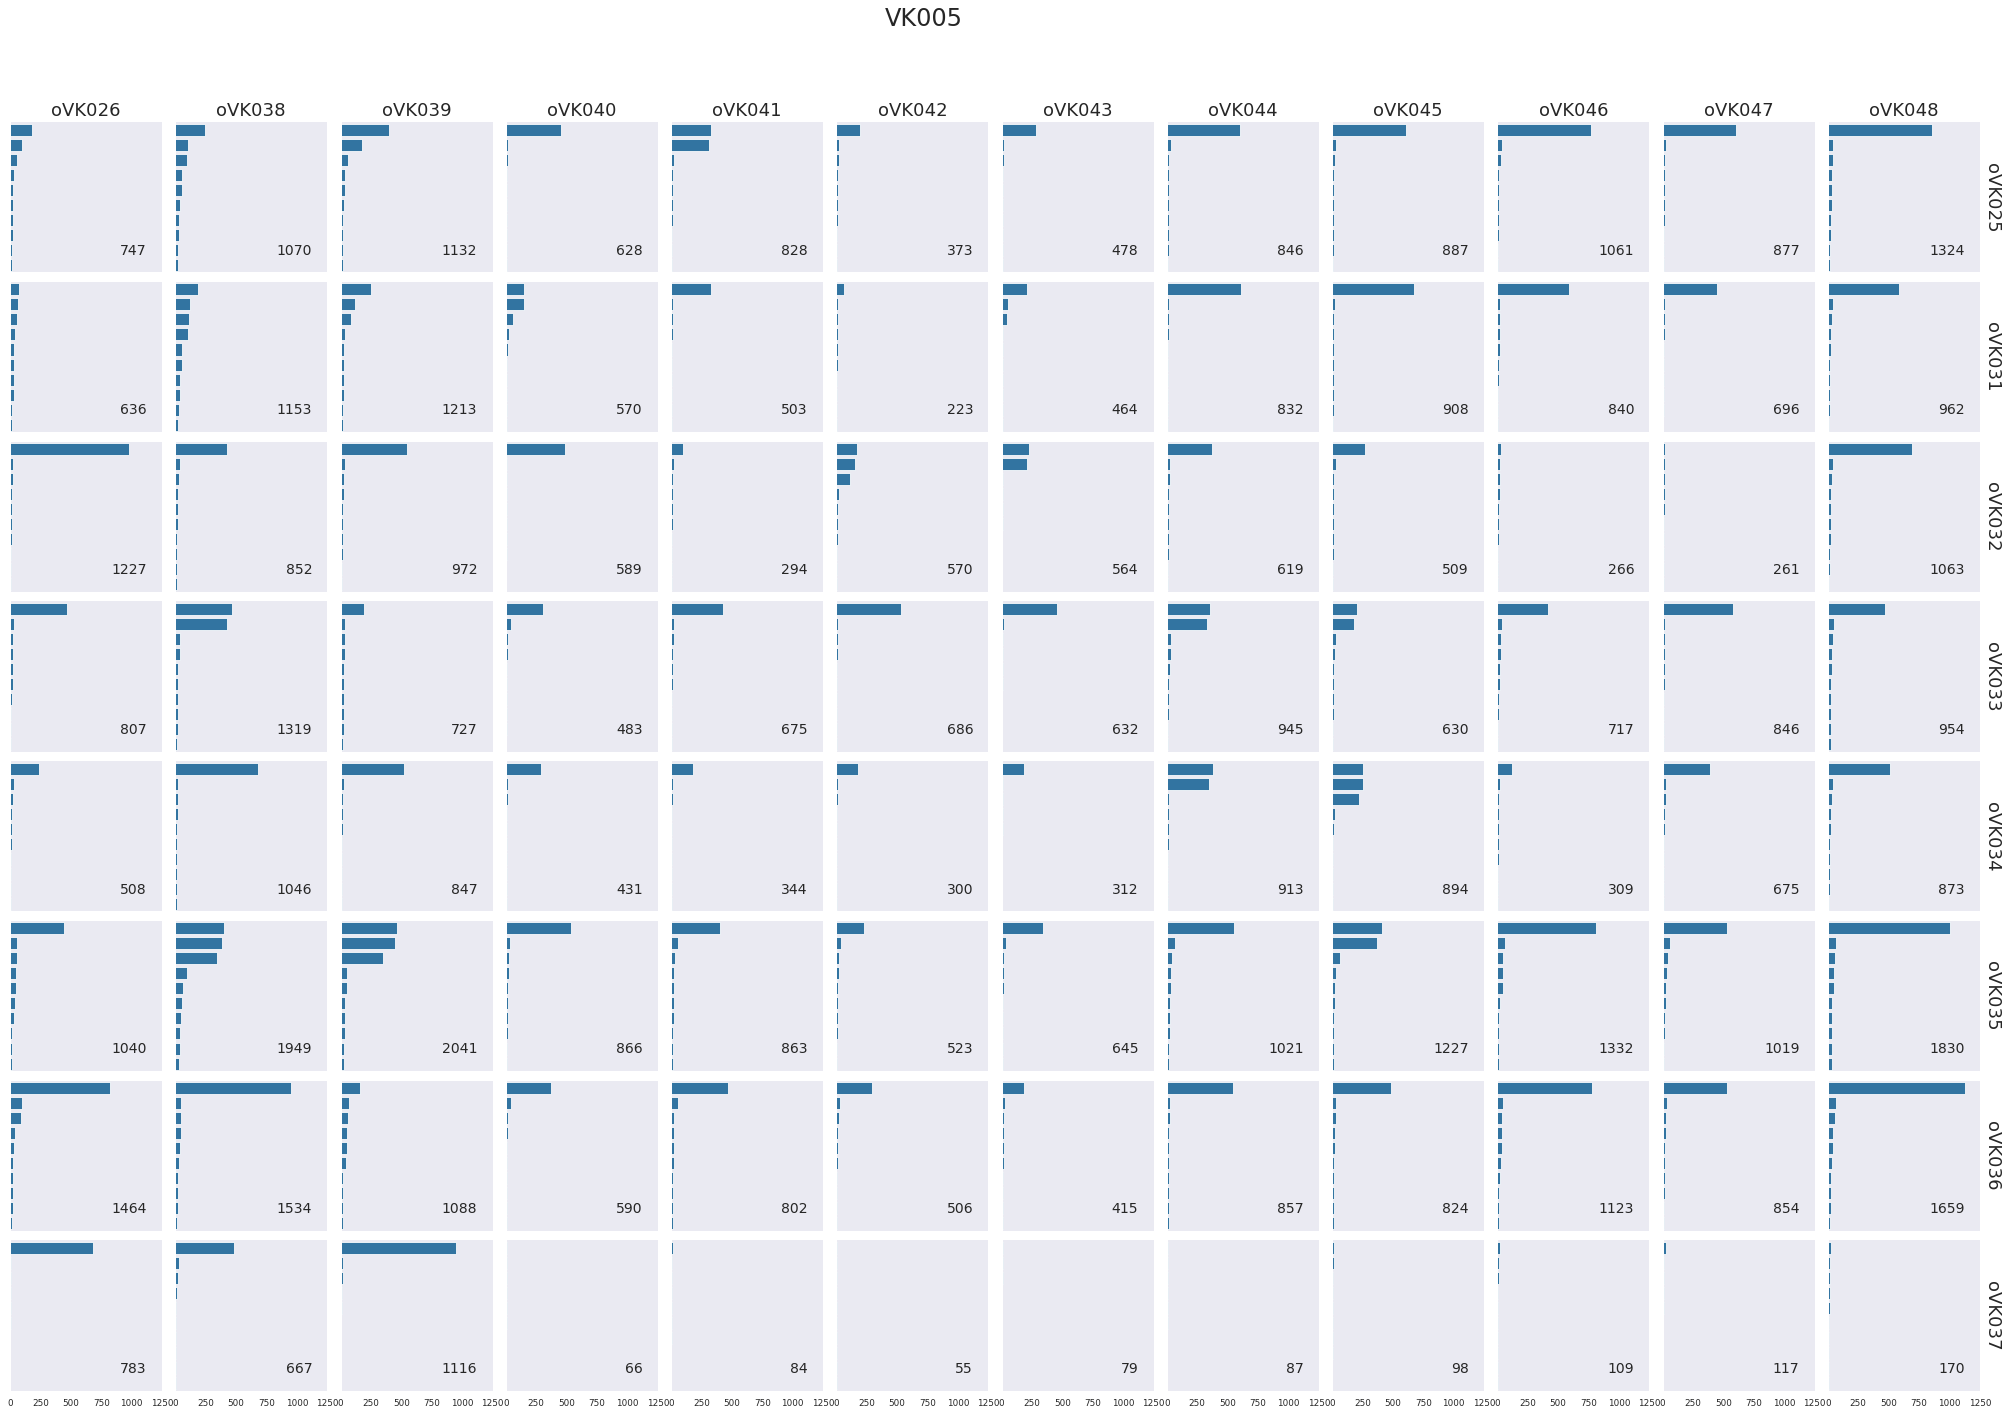

In [43]:
def annotate(data, **kws):
    f = data.iloc[0]['forward_primer']
    r = data.iloc[0]['reverse_primer']
    n = total_reads[(total_reads['forward_primer'] == f) & (total_reads['reverse_primer'] == r)].iloc[0]['count']
    ax = plt.gca()
    ax.text(.9, .1, f"{n}", fontsize=14, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(little_counts_table, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="count",y="barcode", orient='h')
g2.map_dataframe(annotate)
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.9)
g2.fig.suptitle(experiment, fontsize=24)

In [44]:
g2.savefig("histograms.png")

### Find overlapping barcodes

In [45]:
fwd = "oVK025"
rev = "oVK038"
bc = counts_table[(counts_table['forward_primer']==fwd) & (counts_table['reverse_primer']==rev)].nlargest(1,"count")["barcode"].iloc[0]
bc

'CTAAGTGAGTGACAGAGTGTCTCA'

In [46]:
counts_table[counts_table['barcode'] == bc]

,forward_primer,reverse_primer,barcode,count
8,oVK025,oVK026,CTAAGTGAGTGACAGAGTGTCTCA,4
102,oVK025,oVK038,CTAAGTGAGTGACAGAGTGTCTCA,243
185,oVK025,oVK039,CTAAGTGAGTGACAGAGTGTCTCA,8
286,oVK025,oVK040,CTAAGTGAGTGACAGAGTGTCTCA,1
340,oVK025,oVK041,CTAAGTGAGTGACAGAGTGTCTCA,4
397,oVK025,oVK042,CTAAGTGAGTGACAGAGTGTCTCA,1
443,oVK025,oVK043,CTAAGTGAGTGACAGAGTGTCTCA,2
494,oVK025,oVK044,CTAAGTGAGTGACAGAGTGTCTCA,4
559,oVK025,oVK045,CTAAGTGAGTGACAGAGTGTCTCA,2
629,oVK025,oVK046,CTAAGTGAGTGACAGAGTGTCTCA,9


## Experimental

/opt/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


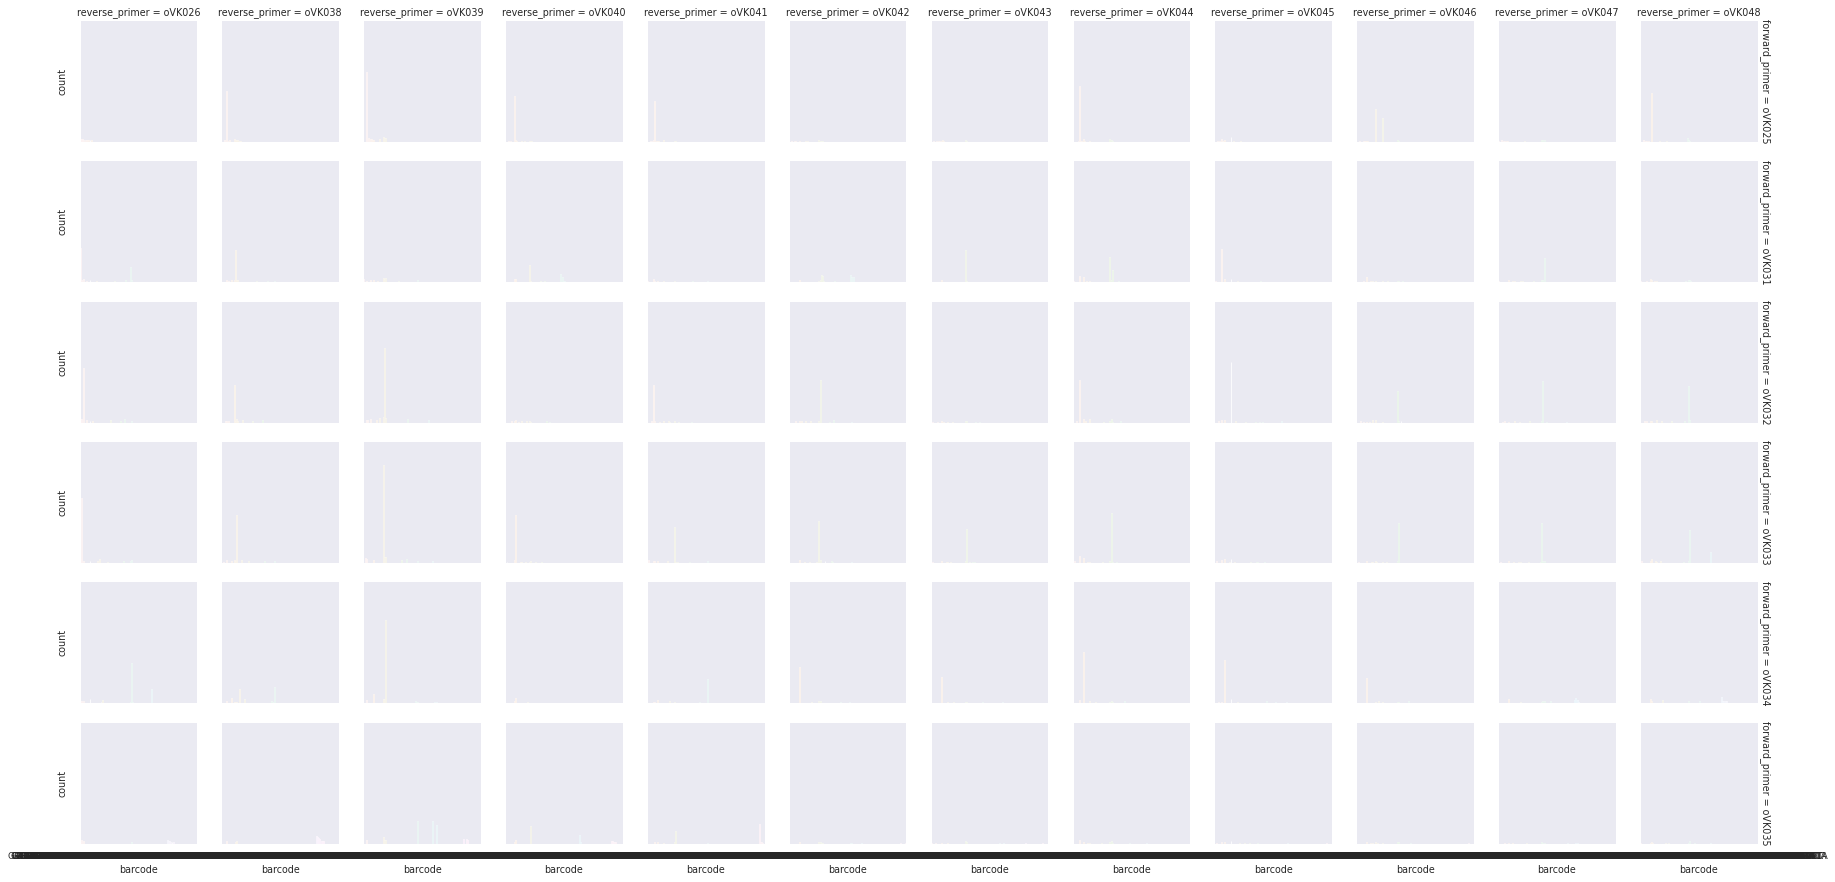

In [100]:
g3 = sns.catplot(
    x="barcode", 
    y="count",
    col="reverse_primer",
    row="forward_primer",
    data=little_counts_table, 
    kind="bar",
    height=2, aspect=1,
    margin_titles=True
)
g3.set_xticklabels(None)
g3.set_yticklabels(None)
g3.set_xlabels(None)
g3.set_ylabels(None)

In [121]:
perl_counts_file = "VK001.barcode_pair_sequence.count.txt"
perl_counts = pd.read_table(perl_counts_file, sep='\t', names=["primer1","primer2","sequence","count"])
perl_counts

,primer1,primer2,sequence,count
0,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124
1,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788
2,F_oVK032,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600
3,F_oVK025,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599
4,F_oVK031,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545
...,...,...,...,...
8176,F_oVK037,R_oVK045,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
8177,F_oVK037,R_oVK046,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
8178,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
8179,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1


In [129]:
perl_counts['direction1'] = perl_counts.apply(
    lambda row: primer_lookup[ row['primer1'][2:] ]['direction'],
    axis = 1
)

perl_counts['direction2'] = perl_counts.apply(
    lambda row: primer_lookup[ row['primer2'][2:] ]['direction'],
    axis = 1
)

perl_counts

,primer1,primer2,sequence,count,direction1,direction2
0,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124,F,R
1,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788,F,R
2,F_oVK032,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600,F,R
3,F_oVK025,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599,F,R
4,F_oVK031,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545,F,R
...,...,...,...,...,...,...
8176,F_oVK037,R_oVK045,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,F,R
8177,F_oVK037,R_oVK046,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,F,R
8178,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,F,R
8179,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,F,R


In [142]:
perl_counts['forward_primer'] = perl_counts.apply(
    lambda row: primer_lookup[ row['primer2'][2:] ]['direction'],
    axis = 1
)

perl_counts['forward_primer'] = perl_counts['primer1'].where(
    perl_counts['direction1'] == 'F',
    perl_counts['primer2']
)

perl_counts['reverse_primer'] = perl_counts['primer1'].where(
    perl_counts['direction1'] == 'R',
    perl_counts['primer2']
)

perl_counts['forward_primer'] = perl_counts['forward_primer'].apply(lambda s: s[2:])
perl_counts['reverse_primer'] = perl_counts['reverse_primer'].apply(lambda s: s[2:])

perl_counts = perl_counts.drop(['primer1','primer2','direction1','direction2'], axis=1)

perl_counts

,sequence,count,forward_primer,reverse_primer
0,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124,oVK033,oVK039
1,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788,oVK034,oVK039
2,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600,oVK032,oVK039
3,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599,oVK025,oVK039
4,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545,oVK031,oVK039
...,...,...,...,...
8176,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK037,oVK045
8177,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK037,oVK046
8178,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK037,oVK047
8179,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK037,oVK047


In [147]:
little_perl_counts = perl_counts.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10))).reset_index()
little_perl_counts

,forward_primer,reverse_primer,sequence,count
0,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1448
1,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,160
2,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,73
3,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,70
4,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,70
...,...,...,...,...
757,oVK037,oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2
758,oVK037,oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
759,oVK037,oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
760,oVK037,oVK048,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,4


[Text(0, 0.5, '')]

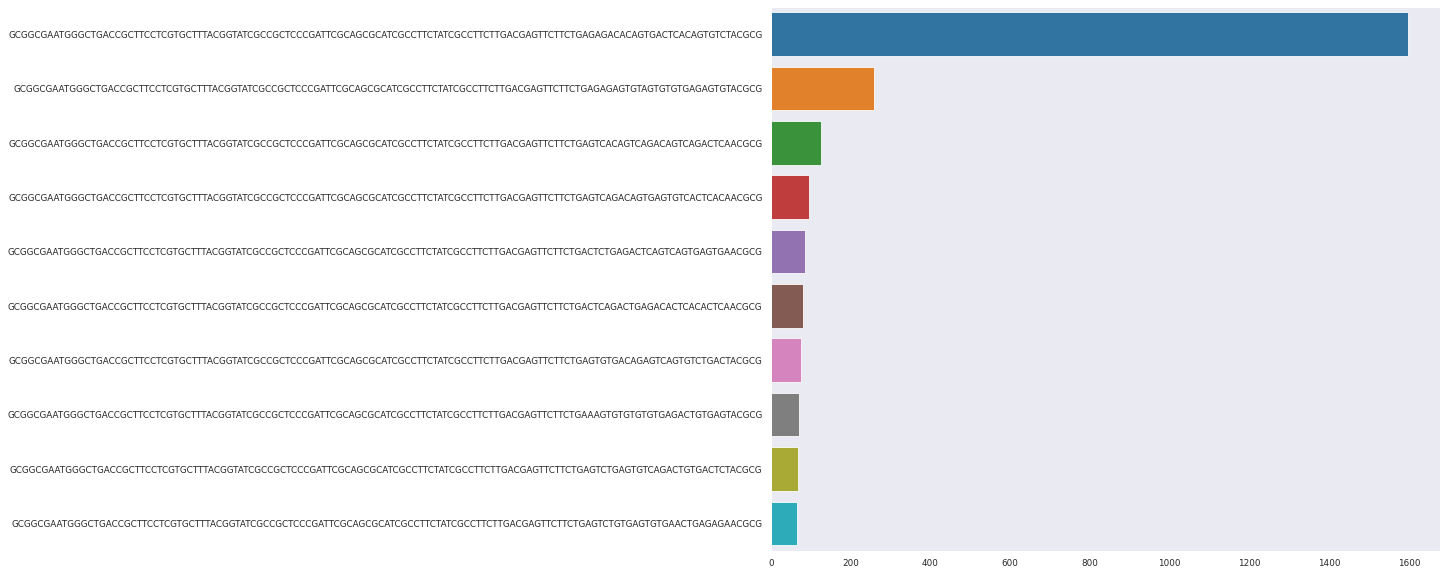

In [152]:
sns.set_style("dark")
sns.set_context("paper")
f, ax = plt.subplots()
f.set_size_inches(12,10)
g = sns.barplot(
        y = "sequence",
        x = "count",
        data=little_perl_counts[
            (little_perl_counts['forward_primer']=='oVK025') & 
            (little_perl_counts['reverse_primer']=='oVK039')].sort_values("count", ascending=False).head(10),
        orient='h', ax=ax
)
g.set(xlabel=None)
g.set(ylabel=None)

Text(0.5, 0.98, 'VK001 - perl output')

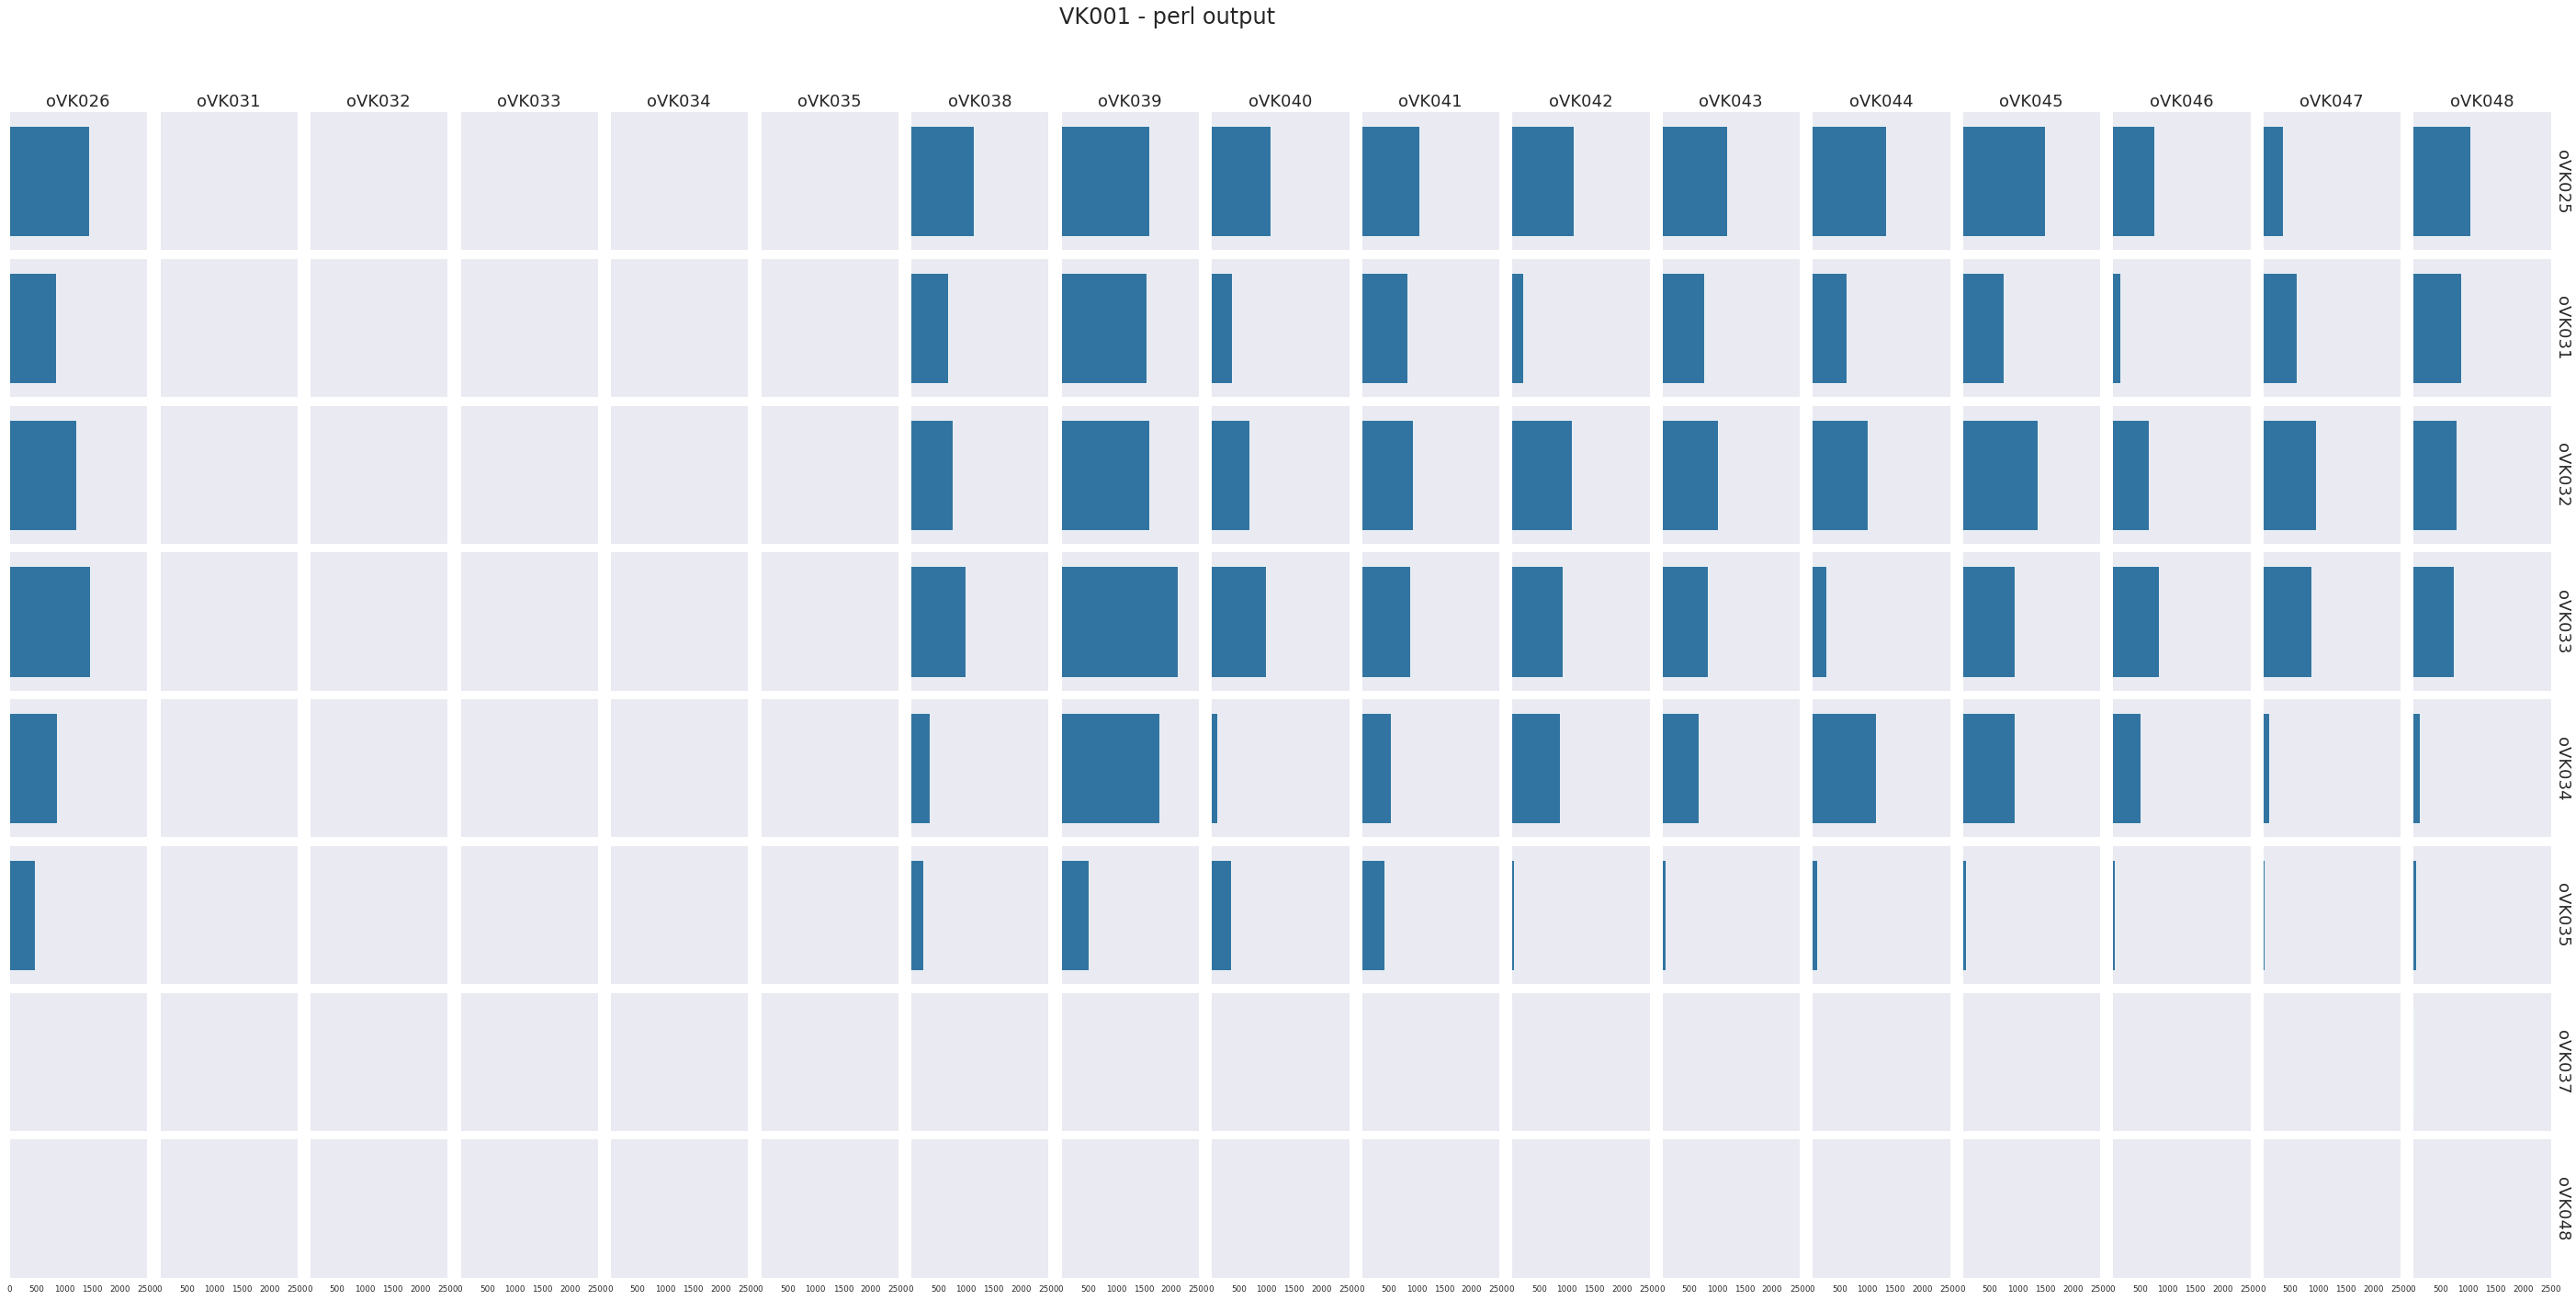

In [148]:
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(little_perl_counts, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="count",y="sequence", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.9)
g2.fig.suptitle("VK001 - perl output", fontsize=24)

In [145]:
perl_counts[
    (perl_counts['forward_primer']=='oVK031') & 
    (perl_counts['reverse_primer']=='oVK044')].sort_values("count", ascending=False)

,sequence,count,forward_primer,reverse_primer
47,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,619,oVK031,oVK044
61,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,349,oVK031,oVK044
75,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,166,oVK031,oVK044
93,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,124,oVK031,oVK044
218,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,61,oVK031,oVK044
...,...,...,...,...
5690,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK031,oVK044
5689,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK031,oVK044
5688,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK031,oVK044
5687,AGGGAGGCAGCAGCGACAGGCATCCATGGGTGCCATCCTGGGGTGG...,1,oVK031,oVK044


# A Bunch of Stuff I Don't Want to Get Rid of Yet

In [ ]:
def PrintSeqSingleRow(n, direction, table):
    read = table.iloc[n]
    if direction == 'R1':
        intervals = [
                [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
                [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
        sequence = read['R1_sequence']
    elif direction == 'R2':
        intervals = [
                [read['R2_fwd_primer_loc'], read['R2_fwd_primer_loc'] + primer_lookup[read['R2_fwd_primer']]['len'] ],
                [read['R2_rc_primer_loc'], read['R2_rc_primer_loc'] + primer_lookup[read['R2_rc_primer']]['len']],
                read['R2_barcode_loc']
            ]
        sequence = read['R2_sequence']
    else:
        return ""
    # print(intervals)
    highlights = ColorSeq(sequence, intervals)
    return highlights

In [ ]:
for i in range(25):
    print( "{0:4d} {1[R1_fwd_direction]} {1[R1_rc_direction]} {2:4d} {3:4d}".format(
        i, reads_table.iloc[i], len(reads_table.iloc[i]['R1_sequence']), len(reads_table.iloc[i]['R2_sequence'])) )

In [ ]:
def PrintSeqMultiRow(n, table):
    read = table.iloc[n]
    highlights = ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
            [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
        ]
    )
    highlights += '\n' + ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_pre_loc'], read['R1_pre_loc'] + len(reference_sequence_pre) ],
            [read['R1_post_loc'], read['R1_post_loc'] + len(reference_sequence_post) ]
        ]
    )
    highlights += '\n' + ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_pre_loc'] + len(reference_sequence_pre), read['R1_post_loc']]
        ]
    )
    return highlights

In [ ]:
h=PrintSeqMultiRow(1, reads_table)
print(h)

In [ ]:
for i in range(25):
    print( "{0:4d} {2:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction'], len(reads_table.iloc[i]['R1_sequence'])), PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', reads_table.iloc[i]['sequence'])
    print()

In [ ]:
from colored import bg, fg, attr
from itertools import chain

def SplitString(s, indices):
    return [s[i:j] for (i,j) in zip( indices[:-1], indices[1:] ) ]

def InsertCodes(s, code_tuples, default_code=bg(0)+fg(15)):
    code_tuples.sort()
    indices = [0] + [i[0] for i in code_tuples] + [len(s)]
    codes = [i[1] for i in code_tuples] + [default_code]
    substrings = SplitString(s, indices)
    return default_code + ''.join( chain(*zip(substrings,codes)) )

def DisplayRow(row):
    display_string = row['R1_sequence']
    default_fg = fg('white')
    default_bg = bg('black')
    color_codes=[
        (0, default_fg + default_bg),
        # forward primer
        (row['R1_fwd_primer_loc'], bg('light_gray')),
        (row['R1_fwd_primer_loc']+primer_lookup[ row['R1_fwd_primer'] ]['len'], default_bg),
        # reverse primer
        (row['R1_rc_primer_loc'], bg('light_gray')),
        (row['R1_rc_primer_loc']+primer_lookup[ row['R1_rc_primer'] ]['len'], default_bg),
        # pre-flanking sequence
        (row['R1_pre_loc'], attr('bold')+fg('navy_blue')),
        (row['R1_pre_loc']+len(reference_sequence_pre), attr('res_bold')+default_fg),
        # post-flanking sequence
        (row['R1_post_loc'], attr('bold')+fg('navy_blue')),
        (row['R1_post_loc']+len(reference_sequence_post), attr('res_bold')+default_fg),
        ]
    if row['R1_fwd_direction']=='F':
        # barcode
        color_codes += [
            (row['R1_pre_loc']+len(reference_sequence_pre), fg('light_blue')+bg('grey_85')),
            (row['R1_post_loc'], default_fg + default_bg)
        ]
    else:
        # barcode
        color_codes += [
            (row['R1_post_loc']+len(reference_sequence_post), fg('light_blue')+bg('grey_85')),
            (row['R1_pre_loc'], default_fg + default_bg)
        ]
    return InsertCodes(display_string, color_codes)

# following not done: need to take out the R1 and pass in 'fwd_primer_loc', etc
def DisplaySeq(seq, locations):
    display_string = seq
    default_fg = fg('white')
    default_bg = bg('black')
    color_codes=[
        (0, default_fg + default_bg),
        # forward primer
        (locations['fwd_primer_loc'], bg('dark_gray')),
        (locations['fwd_primer_loc'] + locations['fwd_primer_len'], default_bg),
        # reverse primer
        (locations['rc_primer_loc'], bg('dark_gray')),
        (locations['rc_primer_loc'] + locations['rc_primer_len'], default_bg),
        # pre-flanking sequence
        (locations['pre_loc'], attr('bold')),
        (locations['pre_loc']+len(reference_sequence_pre), attr('res_bold')+default_fg),
        # post-flanking sequence
        (locations['post_loc'], attr('bold')),
        (locations['post_loc']+len(reference_sequence_post), attr('res_bold')+default_fg),
        ]
    if locations['direction']=='F':
        # barcode
        color_codes += [
            (locations['pre_loc'] + len(reference_sequence_pre), fg('light_blue')+bg('grey_85')),
            (locations['post_loc'], default_fg + default_bg)
        ]
    else:
        # barcode
        color_codes += [
            (locations['post_loc'] + len(reference_sequence_post), fg('light_blue')+bg('grey_85')),
            (locations['pre_loc'], default_fg + default_bg)
        ]
    return InsertCodes(display_string, color_codes)

# Need to reverse the direction for 'R' reads
def DisplayRowWithDirection(row, read):
    # row is a row of reads_table
    # read = 1 or 2
    if read == 1:
        readchar = 'R1'
    else:
        readchar = 'R2'
    if row[readchar + '_fwd_direction'] == 'F':
        direction = 'F'
        seq = row[readchar + '_sequence']
        postrx = lambda x: x
    else:
        direction = 'R'
        seq = row[readchar + '_sequence'][::-1]
        l = len(seq)
        postrx = lambda x: l - 1 - x # not working
    
    locations = {
        'fwd_primer_loc':postrx( row[readchar + '_fwd_primer_loc'] ),
        'fwd_primer_len':primer_lookup[ row[readchar + '_fwd_primer'] ]['len'],
        'rc_primer_loc':postrx( row[readchar + '_rc_primer_loc'] ),
        'rc_primer_len':primer_lookup[ row[readchar + '_rc_primer'] ]['len'],
        'pre_loc':postrx( row[readchar + '_pre_loc'] ),
        'post_loc':postrx( row[readchar + '_post_loc'] ),
        'fwd_primer':row[readchar + '_fwd_primer'],
        'rc_primer':row[readchar + '_rc_primer']
    }
    locations['direction']=direction,
    
    return DisplaySeq(seq, locations)

In [ ]:
print(
    DisplayRow( reads_table.iloc[1] )
)
print(
    DisplayRow( reads_table.iloc[2] )
)
print(
    DisplayRow( reads_table.iloc[3] )
)

In [ ]:
print(
    DisplayRowWithDirection( reads_table.iloc[1], 1 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[1], 2 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[2], 1 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[2], 2 )
)

In [ ]:
with open('reads.txt', 'w') as f:
    f.write( DisplayRowWithDirection( reads_table.iloc[1], 1 ) + '\n' )
    f.write( DisplayRowWithDirection( reads_table.iloc[1], 2 ) + '\n\n' )
    f.write( DisplayRowWithDirection( reads_table.iloc[2], 1 ) + '\n' )
    f.write( DisplayRowWithDirection( reads_table.iloc[2], 2 ) + '\n' )


In [ ]:
for i in range(25):
    print( "{0:4d} {2:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction'], len(reads_table.iloc[i]['R1_sequence'])), PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', PrintSeqOriented(i, reads_table) )
    print()